<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/Mining_frequent_subgraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
df

,login,name
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1328,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1329,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1330,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1331,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples


In [18]:
df['login'] = df['login'].apply(lambda x: 'User: '+x)
df['name'] = df['name'].apply(lambda x: 'Repo: '+x)

In [19]:
# Build the adjacency matrix
am = pd.crosstab(df['login'], df['name']).astype(float)
idx = am.columns.union(am.index)
am = am.reindex(index = idx, columns=idx, fill_value=0.0)

Graph with 262 nodes and 192 edges


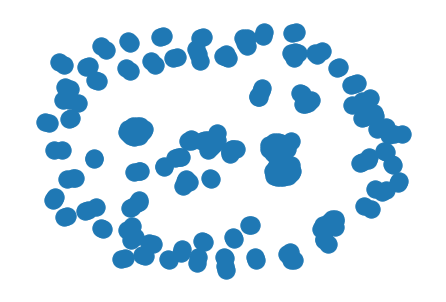

In [20]:
G = nx.from_numpy_matrix(am.to_numpy())
plt.figure(1)
nx.draw(G)
print(nx.info(G))

Graph with 262 nodes and 664 edges


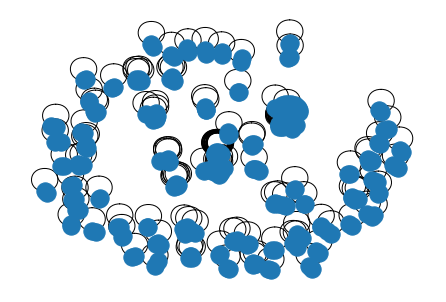

In [21]:
matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def  cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = am.loc[i].to_numpy()[:repo_len]
        aux_vector_b = am.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        # print(i, j, score)
        aux_matrix.at[i, j] = score

#%%
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        am.at[row, column] = aux
        # if (aux == am.at[row, column]) ==  False:
        #     print(aux, row, column)

# %%
# Build graph from matrix, after user-user connections
G = nx.from_numpy_matrix(am.to_numpy())
plt.figure(2)
nx.draw(G)
print(nx.info(G))

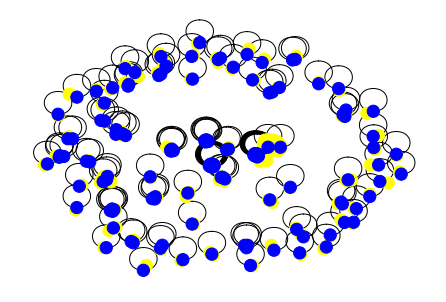

In [22]:
# Initialise the grah
G = nx.MultiGraph()


# Save edges with their weights
edges = []

for row in am.index:
    vector = am.loc[row].to_numpy()
    for i, j in zip(vector, am.columns):
        if i > 0:
            edges.append((row[6:],j[6:],i)) # for nx.Graph() use edges.append((row[6:],j[6:],{'weight': i}))
 
# Save nodes
nodes = []

for name in am.index:
    if name.startswith('User: '):
        nodes.append((name[6:],{"color": "blue"})) #Users are blue
    elif name.startswith('Repo: '):
        nodes.append((name[6:],{"color": "yellow"})) #Repos are yellow

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)    # for nx.Graph() use edges.add_edges_from(edges)
pos = nx.spring_layout(G, seed=52)  # positions for all nodes
# Set nodes colors, blue for users, yellow for repos.
colors = nx.get_node_attributes(G, "color")
node_colors = [colors.get(node) for node in G.nodes()]

# List all users #https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling
users = [key for key,value in nx.get_node_attributes(G,'color').items() if value == 'blue']
labels = {}    
for node in G.nodes():
    if node in users:
        labels[node] = node

#%%
fig = plt.figure(3)
nx.draw(G,pos = pos, node_color=node_colors, node_size=150, with_labels=False)
#nx.draw_networkx_labels(G,pos,labels,font_size=12)
plt.show()

In [23]:
nx.write_edgelist(G, "test_edgelist", delimiter=' ', data=False)

In [24]:
am.shape

(262, 262)

In [25]:
%%capture
!pip install gspan-mining

In [26]:
from gspan_mining.config import parser
from gspan_mining.main import main

In [31]:
args_str = '-s 2 -d True -p True /content/drive/MyDrive/Socialz/otherexample.txt'
FLAGS, _ = parser.parse_known_args(args=args_str.split())

t # 0
v 0 2
v 1 2
e 0 1 2

Support: 2


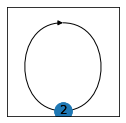


-----------------

t # 1
v 0 2
v 1 2
v 2 2
e 0 1 2
e 0 2 2

Support: 2


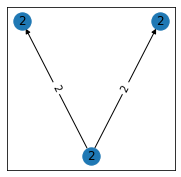


-----------------

Read:	0.0 s
Mine:	0.61 s
Total:	0.61 s


In [32]:
gs = main(FLAGS)